In [70]:
#import librares
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as pytl
import math

In [207]:
def get_counts_in_cluster(data_list, starts, ends):
    counts = []
    for i in range(len(starts)):
        count = np.count_nonzero((data_list > starts[i]) & (data_list < ends[i]))
        counts.append(count)
    return counts

In [205]:
def cluster_KDE(data_list, a, b):
    
    kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(data_list)
    #a = math.trunc(data_list[0]) - 1
    #b = math.trunc(data_list[-1]) + 1
    s = linspace(a,b)
    e = kde.score_samples(s.reshape(-1,1))
    print("Score: ", kde.score)
    
    mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
    print("Minima:", s[mi])
    print("Maxima:", s[ma])
    #clusters = data_list[data_list < mi[0]], data_list[(data_list >= mi[0]) * (data_list <= mi[1])], data_list[data_list >= mi[1]]
    #print("clusters: ", clusters)
    plt.figure(1)
    plt.subplot(211)
    plt.plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
         s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
         s[mi[1]:], e[mi[1]:], 'b',
         s[ma], e[ma], 'go',
         s[mi], e[mi], 'ro')
    
    centers = s[ma]
    starts=np.insert(s[mi],0, data_list[0])
    ends=np.insert(s[mi], centers.size-1, data_list[-1])
    counts= get_counts_in_cluster(data_list, starts, ends)
   
    data= {'start':starts, 'end':ends, 'count':counts, 'center':centers}
    data_frame = pd.DataFrame(data=data) 
    
    plt.subplot(212)     
    plt.scatter(centers, counts, s=s, c="green", alpha=0.4, linewidth=6)
    plt.xlabel('value')
    plt.ylabel('count in cluster')
    plt.show()
    
    return data_frame

In [141]:
def df_to_csv(data_frame, fileName):
    data_frame.to_csv(path_or_buf=fileName)

In [160]:
def plot_histogram(data_list):
    np.random.seed(1)
    N = data_list.shape[0]
    X = data_list
    X_plot = np.linspace(70, 400, 1000)[:, np.newaxis]
    bins = np.linspace(80, 120, 10)

    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # histogram 1
    ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', normed=True)
    ax[0, 0].text(-1, 0.1, "Histogram")

    # histogram 2
    ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', normed=True)
    ax[0, 1].text(-1, 0.1, "Histogram, bins shifted")

    # tophat KDE
    kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    ax[1, 0].text(-1, 0.1, "Tophat Kernel Density")

    # Gaussian KDE
    kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    ax[1, 1].text(-1, 0.1, "Gaussian Kernel Density")

    for axi in ax.ravel():
        axi.plot(X[:, 0], np.zeros(X.shape[0]) - 0.01, '+k')
        axi.set_xlim(70, 200)
        axi.set_ylim(0, 0.1)

    for axi in ax[:, 0]:
        axi.set_ylabel('Normalized Density')

    for axi in ax[1, :]:
        axi.set_xlabel('x')


In [143]:
def plot_median(data_list):
    med = np.median(data_list)
    plt.plot(sorted(data_list), c='b');
    plt.axhline(y=med, label='median tip = %s' % med, c='black');
    plt.legend(fontsize=18);

In [163]:
def get_jenks_breaks(data_list, number_class):
    mat1 = []
    for i in range(len(data_list) + 1):
        temp = []
        for j in range(number_class + 1):
            temp.append(0)
        mat1.append(temp)
    mat2 = []
    for i in range(len(data_list) + 1):
        temp = []
        for j in range(number_class + 1):
            temp.append(0)
        mat2.append(temp)
    for i in range(1, number_class + 1):
        mat1[1][i] = 1
        mat2[1][i] = 0
        for j in range(2, len(data_list) + 1):
            mat2[j][i] = float('inf')
    v = 0.0
    for l in range(2, len(data_list) + 1):
        s1 = 0.0
        s2 = 0.0
        w = 0.0
        for m in range(1, l + 1):
            i3 = l - m + 1
            val = float(data_list[i3 - 1])
            s2 += val * val
            s1 += val
            w += 1
            v = s2 - (s1 * s1) / w
            i4 = i3 - 1
            if i4 != 0:
                for j in range(2, number_class + 1):
                    if mat2[l][j] >= (v + mat2[i4][j - 1]):
                        mat1[l][j] = i3
                        mat2[l][j] = v + mat2[i4][j - 1]
        mat1[l][1] = 1
        mat2[l][1] = v
    k = len(data_list)
    kclass = []
    for i in range(number_class + 1):
        kclass.append(min(data_list))
    kclass[number_class] = float(data_list[len(data_list) - 1])
    count_num = number_class
    while count_num >= 2:  # print "rank = " + str(mat1[k][count_num])
        idx = int((mat1[k][count_num]) - 2)
        # print "val = " + str(data_list[idx])
        kclass[count_num - 1] = data_list[idx]
        k = int((mat1[k][count_num] - 1))
        count_num -= 1
    return kclass

In [208]:
def plot_breaks(data_list, number_class):
    breaks = get_jenks_breaks(data_list, number_class)

    for line in breaks:
        plt.plot([line for _ in range(len(data_list))], 'k--')
    
    starts=[]
    for x in breaks[:-1]:
        starts.append(x[0])
        
    ends = []
    for x in breaks[1:-1]:
        ends.append(x[0])
    ends.append(breaks[-1])
    print(starts)
    print(ends)
    centers=[]
    for i in range(number_class):
        center = (ends[i] - starts[i])/2
        centers.append(center)
        
    counts = get_counts_in_cluster(data_list, starts, ends)
    
    data= {'start':starts, 'end':ends, 'count':counts, 'center':centers}
    data_frame = pd.DataFrame(data=data)
    
    plt.plot(data_list)
    plt.grid(True)
    plt.show()
    
    return data_frame

In [165]:
def plot_histogram_plotly(data_list):
    pytl.set_credentials_file(username='vasihc', api_key='JQwhkmHKi2TUvbGswotq')
    plt.hist(data_list)
    plt.title("Gaussian Histogram")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    fig = plt.gcf()

    py.plot_mpl(fig,  filename='123')


In [148]:
#read weights data
df = pd.read_csv('weightHistories.csv', error_bad_lines=False)
df = df.dropna()
df = df.loc[(df['Height']!=0) & (df['Age (in days)'] > 1000) & (df['Weight']>70)]

y = sorted(df['Weight'].values)
weights = np.array(y).reshape(-1, 1)

df.head()

b'Skipping line 1401: expected 8 fields, saw 9\nSkipping line 1402: expected 8 fields, saw 9\nSkipping line 1403: expected 8 fields, saw 9\nSkipping line 1404: expected 8 fields, saw 9\nSkipping line 1405: expected 8 fields, saw 9\nSkipping line 1406: expected 8 fields, saw 9\nSkipping line 1407: expected 8 fields, saw 9\nSkipping line 7148: expected 8 fields, saw 9\n'


,Resident Info ManagerCommunity Id,Menu Manager Community Id,Resident Id,Measure Date,Weight,Height,Age (in days),First Name
1410,137,1034,48448,9/4/2017 12:00:00 AM,121.6,66.0,27989.0,Richard
1411,137,1034,48448,10/3/2017 12:00:00 AM,124.8,66.0,28018.0,Richard
1412,137,1034,48448,11/1/2017 12:00:00 AM,126.6,66.0,28047.0,Richard
1413,137,1034,48448,12/4/2017 12:00:00 AM,130.0,66.0,28080.0,Richard
1414,137,1034,48448,2/5/2018 12:00:00 AM,128.8,66.0,28143.0,Richard


Score:  <bound method KernelDensity.score of KernelDensity(algorithm='auto', atol=0, bandwidth=5, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)>
Minima: [ 201.63265306  289.3877551   342.04081633  438.57142857]
Maxima: [ 140.20408163  210.40816327  298.16326531  359.59183673  473.67346939]
[  71.          201.63265306  289.3877551   342.04081633  438.57142857]


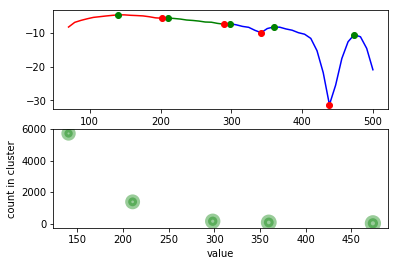

,center,count,end,start
0,140.204082,5721,2.016327e+02,71.000000
1,210.408163,1378,2.893878e+02,201.632653
2,298.163265,146,3.420408e+02,289.387755
3,359.591837,69,4.385714e+02,342.040816
4,473.673469,15,1.901119e+10,438.571429


In [204]:
weights_data_frame = cluster_KDE(weights,70,500)
weights_data_frame.head()

In [150]:
df_to_csv(weights_data_frame, "WeightClustering.csv")

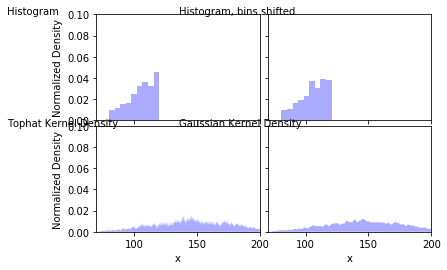

In [161]:
plot_histogram(weights)

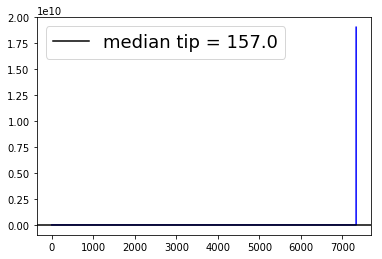

In [152]:
plot_median(weights)

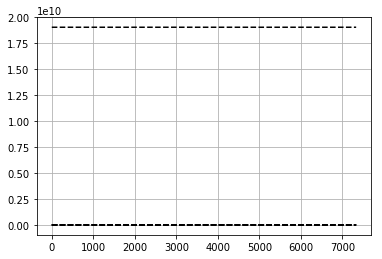

In [166]:
plot_breaks(weights, 5)

In [172]:
#height
heights_df = pd.read_csv('Heights.csv', error_bad_lines=False)
heights_df = heights_df.loc[(heights_df['Height']>=40)&(heights_df['Height']<=100)]
y = sorted(heights_df['Height'].values)
heights = np.array(y).reshape(-1, 1)
heights_df.head()

,Height
9,66.0
10,71.0
11,62.0
12,70.0
13,65.0


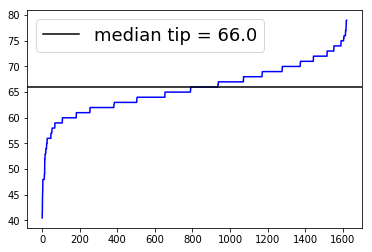

In [178]:
plot_median(heights)

[40.5, 62.5, 68.0]
[62.5, 68.0, 79.0]


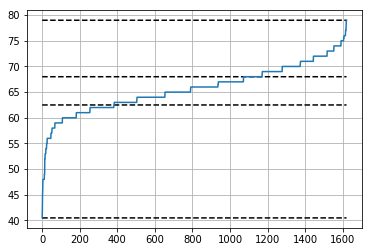

,center,count,end,start
0,11.00,381,62.5,40.5
1,2.75,689,68.0,62.5
2,5.50,448,79.0,68.0


In [209]:
heights_data_frame = plot_breaks(heights,3)
heights_data_frame.head()

In [210]:
df_to_csv(heights_data_frame, "HeightClusters.csv")

In [ ]:
#plot_histogram(heights)

In [180]:
#age
ages_df = pd.read_csv('Ages.csv', error_bad_lines=False)
ages_df= ages_df.loc[(ages_df['Age']>=40) & (ages_df['Age']<=110)]
y = sorted(ages_df['Age'].values)
ages = np.array(y).reshape(-1, 1)
ages_df.head()

,Age
0,95
1,78
2,76
3,90
4,71


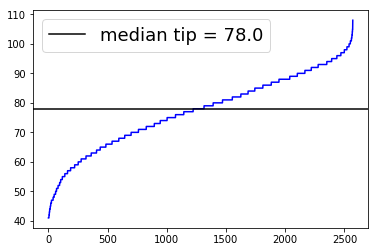

In [181]:
plot_median(ages)

[41, 67, 83]
[67, 83, 108.0]


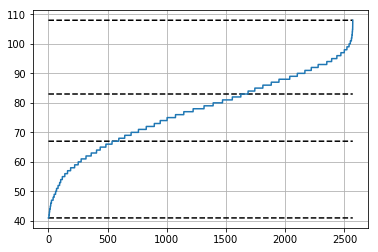

,center,count,end,start
0,13.0,533,67.0,41
1,8.0,1031,83.0,67
2,12.5,884,108.0,83


In [211]:
ages_data_frame = plot_breaks(ages,3)
ages_data_frame.head()

In [212]:
df_to_csv(ages_data_frame, "AgeClusters.csv")

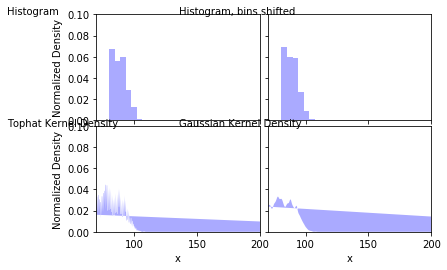

In [185]:
plot_histogram(ages)